In [1]:
import numpy as np
import torch as tch
from matplotlib import pyplot as plt

In [2]:
dev = tch.device("cuda")
dtype = np.float32

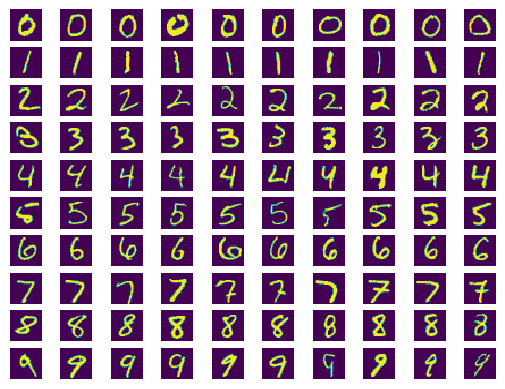

In [19]:
from genpg.dataset import read_train_data, read_test_data

(train_labels, train_images) = read_train_data()
(test_labels, test_images) = read_test_data()

fig, axs = plt.subplots(10, 10)
for col in range(10):
    for row, i in enumerate([i for i, L in enumerate(test_labels) if L == col]):
        if row >= 10:
            break
        ax = axs[col, row]
        ax.axis('off')
        ax.imshow(test_images[i], interpolation='nearest')
fig.show()

In [39]:
from genpg.model import Encoder, Decoder

image_dims = test_images.shape[1:]
latent_dim = 10

enc = Encoder(image_dims, latent_dim).to(dev)
dec = Decoder(latent_dim, image_dims).to(dev)

In [43]:
batch_size = 256

optim = tch.optim.AdamW(
    list(enc.parameters()) + list(dec.parameters()),
    lr=1e-2,
)

In [48]:
for epoch in range(10):
    print(f"{epoch = }")
    perm = np.random.permutation(len(train_labels))
    train_labels = train_labels[perm]
    train_images = train_images[perm]

    losses = []
    for i in range(0, len(train_labels), batch_size):
        labels = tch.from_numpy(train_labels[i : min(i + batch_size, len(train_labels))]).to(dev)
        images = tch.from_numpy(train_images[i : min(i + batch_size, len(train_labels))].astype(dtype) / 255.0).to(dev)

        enc.zero_grad()
        dec.zero_grad()

        x = images
        z_mean, z_var = enc.forward(x)
        z = z_mean + z_var * tch.randn((len(labels), latent_dim), device=dev)
        y = dec.forward(z)

        loss = (x - y).reshape((batch_size, -1)).norm(2, dim=1).mean(0)
        losses.append(loss.item())

        loss.backward()
        optim.step()
    
    print(f"loss = {np.mean(losses)}")

epoch = 0
loss = 5.015287320157315
epoch = 1
loss = 5.0112286202451015
epoch = 2
loss = 5.003192441006925
epoch = 3
loss = 5.0022821284355
epoch = 4
loss = 4.995532491359305
epoch = 5
loss = 4.992868587818552
epoch = 6
loss = 4.989449675539706
epoch = 7
loss = 4.9870392900832154
epoch = 8
loss = 4.98401719357105
epoch = 9
loss = 4.980217412177552


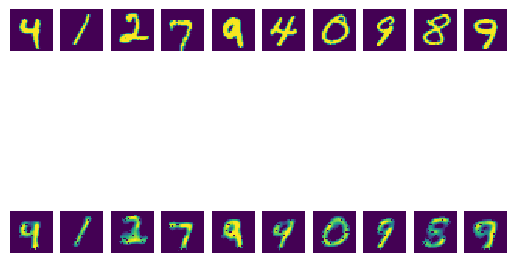

In [49]:
n = 10
x = tch.from_numpy(train_images[0:n].astype(dtype) / 255.0).to(dev)
z_mean, z_var = enc.forward(x)
z = z_mean + z_var * tch.randn((n, latent_dim), device=dev)
y = dec.forward(z)

fig, axs = plt.subplots(2, n)
for col, t in enumerate([x, y]):
    img = t.detach().cpu().numpy().clip(0.0, 1.0)
    for row in range(n):
        ax = axs[col, row]
        ax.axis('off')
        ax.imshow(img[row], interpolation='nearest')
fig.show()